# Jaynes-Cumming Model Hamiltonian

## Initializing the project

The following packages are required in the project.

In [1]:
# %pip install qutip
# %pip install numpy
# %pip install matplotlib

The following imports will be used in the notebook.

In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

def matrix_plot(mat, title=""):

    fig, (real_part, imag_part) = plt.subplots(1, 2, figsize=(10, 25))

    fig.suptitle(title, y=0.61)

    real_part.set_title("Real Part")

    real_cax = real_part.matshow(np.real(mat))

    divider = make_axes_locatable(real_part)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(real_cax, cax=cax)

    imag_part.set_title("Imaginary Part")

    imag_cax = imag_part.matshow(np.imag(mat))

    divider = make_axes_locatable(imag_part)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(imag_cax, cax=cax)

    plt.tight_layout()

## Jaynes-Cumming Hamiltonian Setup: Qubit-Resonator

The Jaynes-Cumming Hamiltonian used in the experiment is in the following form:

$$ H = \frac{1}{2} \Omega_q \sigma_z + \Omega_r a^\dagger a + (g(t)\sigma_+ a + g^* (t) \sigma_- a^\dagger)$$

where $\Omega_q = \hbar \omega_q, \Omega_r = \hbar \omega_r$. Here, we will set $\hbar = 1$

### Initialization the qubit and resonator constants

In this part, we set the number of Fock state in resonator to be sufficiently large number, as in the reality the number of Fock state approaches infinity. The $\Omega_q$, $\Omega_r$ is the frequency of the qubit and resonator, respectively. The times vector is also introduced here.

In [4]:
# Numbers of Fock states

resonator_fock_num = 15

# Frequency

omega_q = 1.0 * 2 * np.pi   # Qubit
omega_r = 1.0 * 2 * np.pi   # Resonator

# Time Vector

times = np.linspace(0.0, 10.0, 2000)

Here, we must define the operator on the space. The bosonic resonator is on the sequence space $l^2(\mathbb{N})$, where $l^2(\mathbb{N})$ is defined by $\{(c_k)_{n=1}^\infty \in \mathbb{C}^\mathbb{N} | \sum_{k=1}^\infty |c_k|^2 < \infty\}$. On the other hand, the fermionic qubit is on the $\mathbb{C}^2$ represent as the spin state. Therefore, the system is on $\mathbb{C}^2\otimes l^2(\mathbb{N})$. Thus, the identity of the system is written as

$$\mathbb{1} = \mathbb{1}_q \otimes \mathbb{1}_r.$$

The full Hamiltonian with all the space shown is,

$$ H = \frac{1}{2} \Omega_q (\sigma_z \otimes \mathbb{1}_r) + \Omega_r (\mathbb{1}_q \otimes a^\dagger a) + (g(t)\sigma_+ \otimes a + g^* (t) \sigma_- \otimes a^\dagger)$$


**Note**: In this program, the spin state $\left| \psi \right> = \left[ \begin{matrix} \alpha \\ \beta \end{matrix} \right]$ is defined in the following convention:

$$ \left| g \right> = \left[ \begin{matrix} 1 \\ 0 \end{matrix} \right], \quad \left| e \right> = \left[ \begin{matrix} 0 \\ 1 \end{matrix} \right] $$

where $\left| g \right>, \left| e \right>$ are ground and excited state, respectively. Therefore, `destroy(2)` and `create(2)` refer to

$$\sigma_- = \left[
    \begin{matrix}
        0 & 1 \\
        0 & 0
    \end{matrix}
\right], \quad 
\sigma_+ = \left[
    \begin{matrix}
        0 & 0 \\
        1 & 0
    \end{matrix}
\right],$$

respectively, while the convention of `sigmam()` and `sigmap()` in QuTiP are,

$$\sigma_- = \left[
    \begin{matrix}
        0 & 0 \\
        1 & 0
    \end{matrix}
\right], \quad 
\sigma_+ = \left[
    \begin{matrix}
        0 & 1 \\
        0 & 0
    \end{matrix}
\right],$$

respectively.

In [5]:
# Operators

### Pauli

pauli_x = tensor([sigmax(), qeye(resonator_fock_num)])
pauli_y = tensor([sigmay(), qeye(resonator_fock_num)])
pauli_z = tensor([sigmaz(), qeye(resonator_fock_num)])

### Annihilation Operator for Qubit and Resonator

sm_q = tensor([destroy(2), qeye(resonator_fock_num)])
a = tensor([qeye(2), destroy(resonator_fock_num)])

### Number Operators for Qubit and Resonator

num_q = sm_q.dag() * sm_q
num_r = a.dag() * a

Noise in Semiconductors: Spectrum of a Two-Parameter Random Signal - https://doi.org/10.1063/1.1721637

## Random Telegraph Noise

The RTN (Random Telegraph Noise) is introduced here. Following https://journals.aps.org/pra/pdf/10.1103/PhysRevA.52.619, random-phase telegraph is implemented.

$\tau_0, \tau_1$ (refer to `tau_0` and `tau_1`) are the mean lifetimes of the state $0$ and $1$ respectively. One can see that the probability of the state being $0$ is $\frac{\tau_0}{\tau_0 + \tau_1}$ and vice versa. The starting state is set to be $1$. The probability of staying at 1 after being in state 1 for time $dt$ is $P_{11}$ (refer to `prob_11`) is

$$ P_{11} (dt) = \frac{1}{\tau_0+\tau_1}\left(\tau_0 e^{-\left(\frac{1}{\tau_0} + \frac{1}{\tau_1}\right) dt}  + \tau_1 \right)$$

Therefore, the $P_{00}$ (refer to `prob_00`) is

$$ P_{00} (dt) = \frac{1}{\tau_0+\tau_1}\left(\tau_1 e^{-\left(\frac{1}{\tau_0} + \frac{1}{\tau_1}\right) dt}  + \tau_0 \right)$$

To create the signal, the value `coin_toss` is the value randomed between $0$ and $1$. Now, the `prob_no_jump` is the probability that no jump will occur, in which the parameter inserted is the difference between the latest jump timestamp (refer to `latest_jump`) and the current timestamp. If the value of `coin_toss` is less than `prob_no_jump` value, the state stays the same; otherwise, the flip occurs and the latest jump timestamp is set to be current timestamp.

The generated telegraph noise is then added to the coupling strength using the following equation,

$$ g(t) = g_0 e^{-i \phi(t)} \quad, \phi (t) = 2\pi \phi_0 \mathrm{RTN}(t)$$

where $\phi_0$ (refer to `phase_fluc`) is the amplitude of fluctuation in phase and $\mathrm{RTN}(t)$ is the telegraph noise at time $t$.


#### Setting the coupling strength, phase fluctuation, and probability of getting 0,1

In [6]:
# Qubit-Resonator Coupling strength

g_res = 0.5 * 2 * np.pi     # Coupling Strength

# Random Telegraph Noise

phase_fluc = 0.25              # The strength of 'random-phase' telegraph

tau_0 = 0.9
tau_1 = 0.1

#### Generating the Random Telegraph Signal

In [7]:
prob_11 = lambda t : (tau_0 * np.exp( - ( 1/tau_0 + 1/tau_1 ) * t ) + tau_1 )/ (tau_0 + tau_1)
prob_00 = lambda t : (tau_1 * np.exp( - ( 1/tau_0 + 1/tau_1 ) * t ) + tau_0 )/ (tau_0 + tau_1)

latest_jump = 0
current_state = 1
rtn = []

for i in times:
    prob_no_jump = prob_11 if current_state == 1 else prob_00
    coin_toss = np.random.random()
    if (coin_toss < prob_no_jump(i-latest_jump)):
        rtn.append(current_state)
    else:
        current_state = 0 if current_state == 1 else 1      # Flip the state
        rtn.append(current_state)
        latest_jump = i

#### Override the noise (optional)

- Set the time window
- Set the rectangular pulse wave

In [8]:
# Set the rectangular pulse wave

# period = 0.5        # Set the period
# new_rtn = [ 1 if np.floor(t / period) % 2 == 1 else 0 for t in times ]      

# Set the limited amount of time that qubit subjected to noise

init_time = 1
fin_time = 4

new_rtn = [ rtn[i] if init_time < times[i] and times[i] < fin_time else 0 for i in range(len(times)) ]

# Replacing the noise

rtn = new_rtn

#### Generating $g(t)$ , $g^* (t)$

In [9]:
def func(t): return (g_res * np.exp(phase_fluc * (np.array(rtn)) * 1j * np.pi))

def noisy_func(t): return func(t)

noisy_data = noisy_func(times)
noisy_data_conj = np.conj(noisy_data)

g = Cubic_Spline(times[0], times[-1], noisy_data)
g_conj = Cubic_Spline(times[0], times[-1], noisy_data_conj)

Three Hamiltonians are introduced here: `H_no_noise` is the free Hamiltonian $H_0 = \frac{1}{2} \Omega_q \sigma_z + \Omega_r a^\dagger a$, `H_const_noise` is the Hamiltonian with constant coupling strength $H_{const} = H_0 + g(\sigma_{+} a + \sigma_{-} a^\dagger)$, and `H` is the Hamiltonian with telegraph noise shown in the introduction.

In [10]:
# Hamiltonian

H_0 = 0.5 * omega_q * pauli_z + omega_r * a.dag() * a
H_1 = [[sm_q.dag() * a, g], [sm_q * a.dag(), g_conj]]

H = [H_0] + H_1

H_const_noise = H_0 + g_res * ( sm_q.dag() * a + sm_q * a.dag() )
H_no_noise = H_0

The Hamiltonian is then solved by using Linblad Master Equation. The measurement is on $\sigma_z$ basis, number opereator of qubit and resonator.

$$ \dot{\rho}(t) = -\frac{i}{\hbar}[H(t), \rho(t)] $$

The collapse operator in the later part is omitted, as to examine only the effect of coupling strength incoporate with telegraph noise.

In [11]:
# MeSolve

rho0 = tensor([basis(2, 0), basis(resonator_fock_num, 1)]) # The initial state can be set here...

measurement_basis = [num_q, pauli_z, num_r]

output = mesolve(H, rho0, times, [], measurement_basis)
output_const_coupling = mesolve(H_const_noise, rho0, times, [], measurement_basis)
output_no_noise = mesolve(H_no_noise, rho0, times, [], measurement_basis)

densityM_output = mesolve(H, rho0, times, [])
densityM_const_coupling = mesolve(
    H_const_noise, rho0, times, [])
densityM_no_noise = mesolve(H_no_noise, rho0, times, [])


#### Measurement of Density Operator

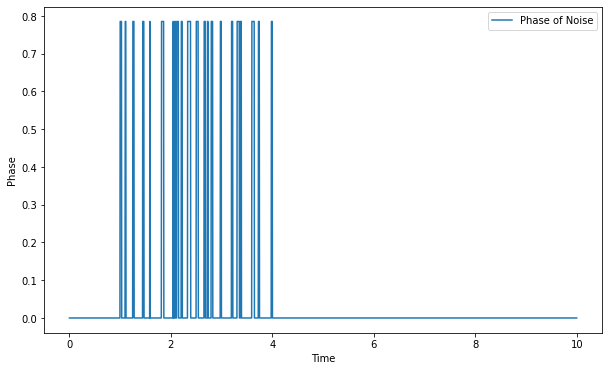

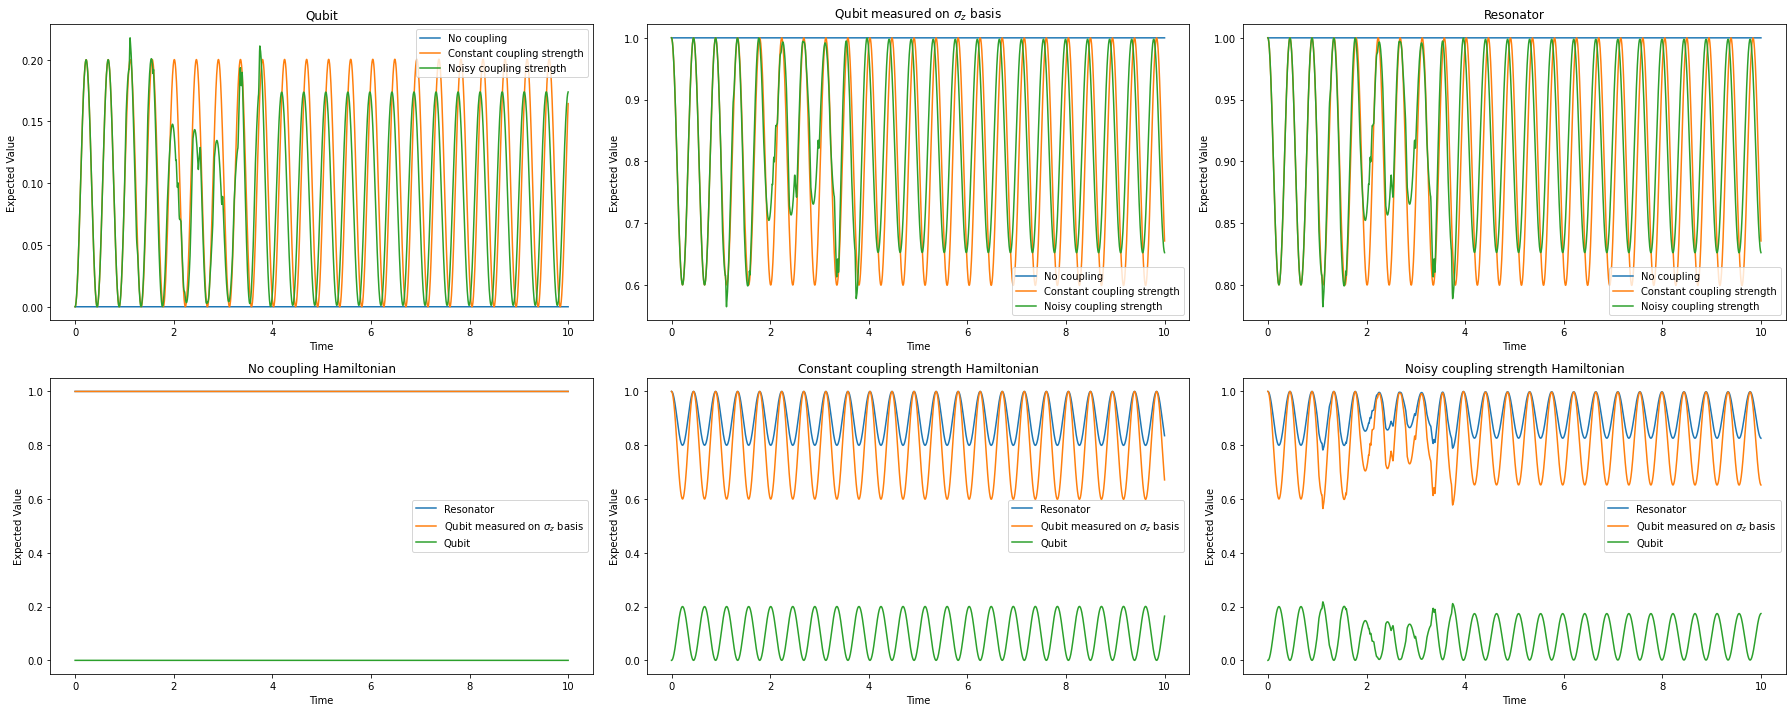

In [12]:
# Telegraph Noise

fig_noise, axes_noise = plt.subplots(1,1, figsize=(10,6))

axes_noise.plot(times, np.angle(noisy_data), label="Phase of Noise")
axes_noise.legend(loc=0)
axes_noise.set_xlabel('Time')
axes_noise.set_ylabel('Phase')

# Expected value of number operators

fig, ((qubit_measure, pauliZ_measure, resonator_measure), (axes_prob_no_coupling, axes_prob_const_coupling, axes_prob_noisy)) = plt.subplots(2,3, figsize=(25,10))

## No Noise

expected_qubit_no_noise = output_no_noise.expect[0]
expected_pauliZ_no_noise = output_no_noise.expect[1]
expected_res_no_noise = output_no_noise.expect[2]

### Constant Coupling strength

expected_qubit_const_coupling = output_const_coupling.expect[0]
expected_pauliZ_const_coupling = output_const_coupling.expect[1]
expected_res_const_coupling = output_const_coupling.expect[2]

### Noisy

expected_qubit = output.expect[0]
expected_pauliZ = output.expect[1]
expected_res = output.expect[2]

### Qubit Measurement

qubit_measure.set_title("Qubit")
qubit_measure.plot(times, expected_qubit_no_noise, label="No coupling")
qubit_measure.plot(times, expected_qubit_const_coupling,
                   label="Constant coupling strength")
qubit_measure.plot(times, expected_qubit, label="Noisy coupling strength")
qubit_measure.legend(loc=0)
qubit_measure.set_xlabel('Time')
qubit_measure.set_ylabel('Expected Value')

### Qubit Measurement on sigma_z basis

pauliZ_measure.set_title("Qubit measured on $\sigma_z$ basis")
pauliZ_measure.plot(times, expected_pauliZ_no_noise,
                    label="No coupling")
pauliZ_measure.plot(times, expected_pauliZ_const_coupling,
                    label="Constant coupling strength")
pauliZ_measure.plot(times, expected_pauliZ,
                    label="Noisy coupling strength")
pauliZ_measure.legend(loc=0)
pauliZ_measure.set_xlabel('Time')
pauliZ_measure.set_ylabel('Expected Value')

### Resonator Measurement

resonator_measure.set_title("Resonator")
resonator_measure.plot(times, expected_res_no_noise, label="No coupling")
resonator_measure.plot(times, expected_res_const_coupling,
                       label="Constant coupling strength")
resonator_measure.plot(times, expected_res, label="Noisy coupling strength")
resonator_measure.legend(loc=0)
resonator_measure.set_xlabel('Time')
resonator_measure.set_ylabel('Expected Value')

### No coupling

axes_prob_no_coupling.set_title("No coupling Hamiltonian")
axes_prob_no_coupling.plot(times, expected_res_no_noise, label="Resonator")
axes_prob_no_coupling.plot(times, expected_pauliZ_no_noise,
                        label="Qubit measured on $\sigma_z$ basis")
axes_prob_no_coupling.plot(times, expected_qubit_no_noise, label="Qubit")
axes_prob_no_coupling.legend(loc=0)
axes_prob_no_coupling.set_xlabel('Time')
axes_prob_no_coupling.set_ylabel('Expected Value')

### Constant coupling strength

axes_prob_const_coupling.set_title("Constant coupling strength Hamiltonian")
axes_prob_const_coupling.plot(
    times, expected_res_const_coupling, label="Resonator")
axes_prob_const_coupling.plot(times, expected_pauliZ_const_coupling,
                              label="Qubit measured on $\sigma_z$ basis")
axes_prob_const_coupling.plot(
    times, expected_qubit_const_coupling, label="Qubit")
axes_prob_const_coupling.legend(loc=0)
axes_prob_const_coupling.set_xlabel('Time')
axes_prob_const_coupling.set_ylabel('Expected Value')

### Noisy coupling strength

axes_prob_noisy.set_title("Noisy coupling strength Hamiltonian")
axes_prob_noisy.plot(times, expected_res, label="Resonator")
axes_prob_noisy.plot(times, expected_pauliZ,
                     label="Qubit measured on $\sigma_z$ basis")
axes_prob_noisy.plot(times, expected_qubit, label="Qubit")
axes_prob_noisy.legend(loc=0)
axes_prob_noisy.set_xlabel('Time')
axes_prob_noisy.set_ylabel('Expected Value')

plt.tight_layout()

### Find g/omega_atom

## Fidelity of the Density Operator

This portion of code is comparing the fidelity of density matrix between constant coupling strength with noisy coupling strength w.r.t. time.

Text(0, 0.5, 'Fidelity')

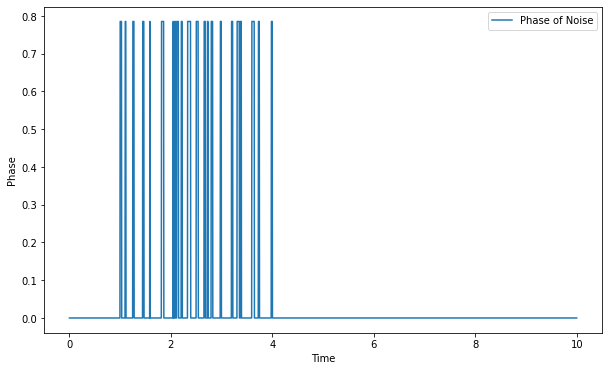

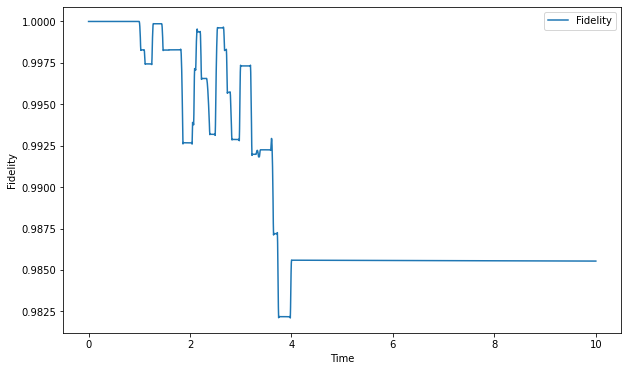

In [13]:
# Telegraph Noise

fig_noise, axes_noise = plt.subplots(1, 1, figsize=(10, 6))

axes_noise.plot(times, np.angle(noisy_data), label="Phase of Noise")
axes_noise.legend(loc=0)
axes_noise.set_xlabel('Time')
axes_noise.set_ylabel('Phase')

fid = []

for i, dm in enumerate(densityM_const_coupling.states):
    fid.append(fidelity(densityM_const_coupling.states[i], densityM_output.states[i]))

fig_fid, axes_fid = plt.subplots(1, 1, figsize=(10, 6))

axes_fid.plot(times, fid, label="Fidelity")
axes_fid.legend(loc=0)
axes_fid.set_xlabel('Time')
axes_fid.set_ylabel('Fidelity')